<a href="https://colab.research.google.com/github/aliakbarbadri/persian-poetry-creator/blob/master/word-lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np
import matplotlib.pyplot as plt

# Data

In [0]:
url = "https://raw.githubusercontent.com/aliakbarbadri/persian-poetry-creator/master/shahname2.txt"
filepath = keras.utils.get_file("shahname.txt", url) 
with open(filepath) as f:
  data = f.read()
texts = data.split("\n")

In [45]:
beyt10 = "\n".join(texts[:20])
len(beyt10.split())

230

In [0]:
corpus = []
length = 20
for i in range(int(20000/length)):
  beyt10 = " \n ".join(texts[i:i+length])
  beyt10 = beyt10.replace("\t"," \t ")
  corpus.append(beyt10)

In [47]:
s = "salam\tkhubi"
a = s.replace("\t", " \t ")
s , a

('salam\tkhubi', 'salam \t khubi')

In [48]:
len(corpus)

1000

In [49]:
corpus[0]

'چو از بلخ بامی به جیحون رسید \t سپهدار لشکر فرود آورید \n بشد شهریار از میان سپاه \t فرود آمد از باره بر شد به گاه \n بخواند او گرانمایه جاماسپ را \t کجا رهنمون بود گشتاسپ را \n سر موبدان بودو شاه ردان \t چراغ بزرگان و اسپهبدان \n چنان پاک تن بود و تابنده جان \t که بودی بر او آشکارا نهان \n ستاره\u200cشناس و گرانمایه بود \t ابا او به دانش کرا پایه بود \n بپرسید ازو شاه و گفتا خدای \t ترا دین به داد و پاکیزه رای \n چو تو نیست اندر جهان هیچ کس \t جهاندار دانش ترا داد و بس \n ببایدت کردن ز اختر شمار \t بگویی همی مر مرا روی کار \n که چون باشد آغاز و فرجام جنگ \t کرا بیشتر باشد اینجا درنگ \n نیامد خوش آن پیر جاماسپ را \t به روی دژم گفت گشتاسپ را \n که میخواستم کایزد دادگر \t ندادی مرا این خرد وین هنر \n مرا گر نبودی خرد شهریار \t نکردی زمن بودنی خواستار \n مگر با من از داد پیمان کند \t که نه بد کند خود نه فرمان کند \n جهانجوی گفتا به نام خدای \t بدین و به دین آور پاک رای \n به جان زریر آن نبرده سوار \t به جان گرانمایه اسفندیار \n که نه هرگزت روی دشمن کنم \t نفرمایمت بد نه خود من کنم \n تو 

In [50]:
print(corpus[0])

چو از بلخ بامی به جیحون رسید 	 سپهدار لشکر فرود آورید 
 بشد شهریار از میان سپاه 	 فرود آمد از باره بر شد به گاه 
 بخواند او گرانمایه جاماسپ را 	 کجا رهنمون بود گشتاسپ را 
 سر موبدان بودو شاه ردان 	 چراغ بزرگان و اسپهبدان 
 چنان پاک تن بود و تابنده جان 	 که بودی بر او آشکارا نهان 
 ستاره‌شناس و گرانمایه بود 	 ابا او به دانش کرا پایه بود 
 بپرسید ازو شاه و گفتا خدای 	 ترا دین به داد و پاکیزه رای 
 چو تو نیست اندر جهان هیچ کس 	 جهاندار دانش ترا داد و بس 
 ببایدت کردن ز اختر شمار 	 بگویی همی مر مرا روی کار 
 که چون باشد آغاز و فرجام جنگ 	 کرا بیشتر باشد اینجا درنگ 
 نیامد خوش آن پیر جاماسپ را 	 به روی دژم گفت گشتاسپ را 
 که میخواستم کایزد دادگر 	 ندادی مرا این خرد وین هنر 
 مرا گر نبودی خرد شهریار 	 نکردی زمن بودنی خواستار 
 مگر با من از داد پیمان کند 	 که نه بد کند خود نه فرمان کند 
 جهانجوی گفتا به نام خدای 	 بدین و به دین آور پاک رای 
 به جان زریر آن نبرده سوار 	 به جان گرانمایه اسفندیار 
 که نه هرگزت روی دشمن کنم 	 نفرمایمت بد نه خود من کنم 
 تو هرچ اندرین کار دانی بگوی 	 که تو چاره‌دا

In [0]:
tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

In [54]:
for k,v in enumerate(tokenizer.word_index):
  if v=="\t":
    print(k)
  elif v=="\n":
    print(k)

0
1


In [0]:
# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

# Model (LSTM)

In [56]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 293, 100)          272100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 293, 300)          301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 293, 300)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1360)              137360    
_________________________________________________________________
dense_3 (Dense)              (None, 2721)              3703281   
Total params: 4,574,341
Trainable params: 4,574,341
Non-trainable params: 0
____________________________________________

In [57]:
history = model.fit(predictors, label, epochs=10)

Epoch 1/10
8284/8284 [==============================] - 507s 61ms/step - loss: 5.2454 - accuracy: 0.1364
Epoch 2/10
8284/8284 [==============================] - 504s 61ms/step - loss: 3.9066 - accuracy: 0.2785
Epoch 3/10
8284/8284 [==============================] - 503s 61ms/step - loss: 2.8982 - accuracy: 0.4267
Epoch 4/10
8284/8284 [==============================] - 503s 61ms/step - loss: 2.1470 - accuracy: 0.5806
Epoch 5/10
8284/8284 [==============================] - 508s 61ms/step - loss: 1.6025 - accuracy: 0.6986
Epoch 6/10
8284/8284 [==============================] - 511s 62ms/step - loss: 1.2106 - accuracy: 0.7849
Epoch 7/10
8284/8284 [==============================] - 513s 62ms/step - loss: 0.9369 - accuracy: 0.8462
Epoch 8/10
8284/8284 [==============================] - 513s 62ms/step - loss: 0.7475 - accuracy: 0.8892
Epoch 9/10
8284/8284 [==============================] - 513s 62ms/step - loss: 0.6183 - accuracy: 0.9168
Epoch 10/10
8284/8284 [==============================] 

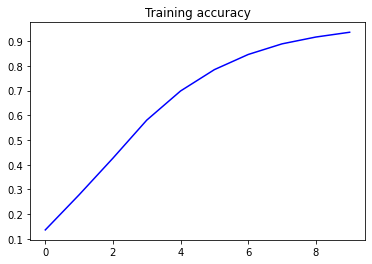

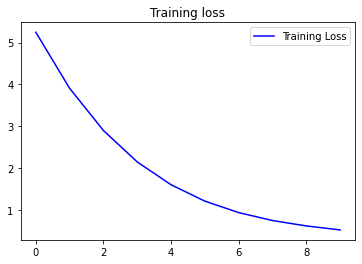

In [58]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [59]:
seed_text = "که ایران چو باغی ست خرم بهار"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
که ایران چو باغی ست خرم بهار و فرجام جنگ 	 کرا بیشتر دینار پاسخ دل اندیشه زریر 
 دگر گر ایدر بدو گفت در نخست 	 بنیک و بد آزرم هرکس بجست 
 بکوشید تا بردل هرکسی 	 ازو رنج بردن نباشد بسی 
 چنین داد پاسخ که هرکس که داد 	 بداد از تن خود همو بود شاد 
 بسان سیاوش سرش را ز تن 	 ببرند و کرگس بپوشد کفن 
 چو بشنید طوس سپهبد برفت 	 به خون ریختن روی بنهاد تفت 
 بدو سرخه پاسخ آیین مر آن را دریغ 	 همان اختر چه دانش ز طوس 
 چو برگردد او از


In [0]:
model.save("word_lstm.h5")

# Model (GRU)

In [63]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(GRU(150, return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 293, 100)          272100    
_________________________________________________________________
gru (GRU)                    (None, 293, 150)          113400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 293, 150)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               75600     
_________________________________________________________________
dense_4 (Dense)              (None, 1360)              137360    
_________________________________________________________________
dense_5 (Dense)              (None, 2721)              3703281   
Total params: 4,301,741
Trainable params: 4,301,741
Non-trainable params: 0
____________________________________________

In [65]:
history = model.fit(predictors, label, epochs=10)

Epoch 1/10
8284/8284 [==============================] - 336s 41ms/step - loss: 4.6766 - accuracy: 0.2113
Epoch 2/10
8284/8284 [==============================] - 337s 41ms/step - loss: 2.5151 - accuracy: 0.5072
Epoch 3/10
8284/8284 [==============================] - 336s 41ms/step - loss: 1.3320 - accuracy: 0.7797
Epoch 4/10
8284/8284 [==============================] - 336s 41ms/step - loss: 0.8330 - accuracy: 0.8910
Epoch 5/10
8284/8284 [==============================] - 337s 41ms/step - loss: 0.5972 - accuracy: 0.9341
Epoch 6/10
8284/8284 [==============================] - 337s 41ms/step - loss: 0.4829 - accuracy: 0.9498
Epoch 7/10
8284/8284 [==============================] - 337s 41ms/step - loss: 0.4121 - accuracy: 0.9588
Epoch 8/10
8284/8284 [==============================] - 336s 41ms/step - loss: 0.3659 - accuracy: 0.9633
Epoch 9/10
8284/8284 [==============================] - 337s 41ms/step - loss: 0.3396 - accuracy: 0.9655
Epoch 10/10
8284/8284 [==============================] 

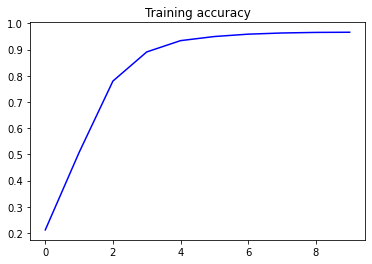

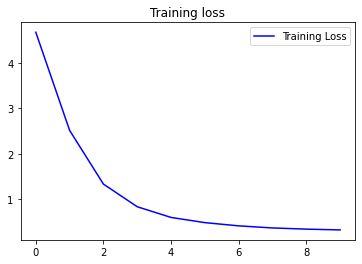

In [66]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [67]:
seed_text = "که ایران چو باغی ست خرم بهار"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

که ایران چو باغی ست خرم بهار فرمان پای 	 روان نامدارنش بنشاندند 
 نخستین سخن گفت بوزرجمهر 	 که ای شاه نیک اختر خوب چهر 
 یکی آرزو کرد موزه فروش 	 اگر شاه دارد بمن بنده گوش 
 فرستاده گوید که این مرد گفت 	 که شاه جهان با خرد باد جفت 
 یکی پور دارم رسیده بجای 	 بفرهنگ جوید همی رهنمای 
 اگر شاه باشد بدین دستگیر 	 که این پاک فرزند گردد دبیر 
 ز یزدان بخواهم همی جان شاه 	 که جاوید باد این سزاوار گاه 
 بدو گفت شاه ای خردمند مرد 	 چرا دیو چشم تو را تیره کرد


In [0]:
model.save("word_gru.h5")